<a href="https://colab.research.google.com/github/patelr01/CoreNLP/blob/master/notebooks/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fraud Detection Case Study**
---

## **Problem Statement:**
1. Please build a model that we can use to flag fraudulent transactions for future banking
activity. You can assume that BANKCORP will not change the structure of its
transactions in the future, meaning that future data will look like the past.
2. Why did you choose this model? What are alternative approaches you would consider?
3. How would you use this model in practice? How much fraud loss do you think it could
prevent? Please provide a dollar estimate.



# **Summary of my approach and results:**
---

**Business context and Assumptions:**  
 - BANKCORP needs a system to identify potentially fraudulent transactions where a customer's account or card has been compromised by a third party.  
 - The goal is to minimize financial losses due to unauthorized transactions while minimizing false positives, thus preserving customer trust.  We assume the customer's intent is good, but their account security has been breached.


**Model solution rationale with the available target:**
 - A classifier model is the most suitable approach for this problem. We have a labeled dataset with fraud = 0 or 1, which provides a ground truth for training a classification model.
 - Additionally, the labels tagged by the fraud agents may have some misses adding to model limitations in correctly predicting fraud. Thus, to mitigate this, we can apply rules based decision on top of the raw model score to avoid negative impact for the customer.

**Sample Data Observations:**
- The given data sample has multiple customer and transaction related features along with fraud label.
- Based on descriptive statistics and exploratory analysis, fraud is very prevalent when transaction amount is high (>$2000). Additionally, transaction amount is right-skewed with lower transactions. We can confirm if this hypothesis is true during model evalulation and feature importance.
- The fraud label is highly imbalanced with only 1.2% of transactions as fraud and remaining non-fraud. Thus, we will need to handle data imbalance during model training.
- All the transactions are originated from zip code 28007, thus location based features will not provide much value.
- Transaction category is highly skewed with es_transportation being ~85%
- Target analysis also shows fraud is homogenous across other features except for amount as discussed above.

**Sample Setup:**
- Divide the data into train, validation and test.
- The test sample will be used to test for final model performance and estimate for $ fraud losses.

**Feature Engineering:**
- Calculated transaction based trended features at customer level like mean, standard deviation, sum and count in last 24 hours, 72 hours, 30 days and also added ratio of 24h:72h and so on. This is especially useful to evaulate the velocity of new transactions for a customer and helps identify if there is a significant change in the customer's recent transaction behavior.
- We also need to account for data leakage for first 30 days in the above scenario. I have used the full sample and replaced NaN values with mean in later stage due to the low fraud datapoints and limited analysis time. This is not the best solution and can be improved further.

**Modelling Setup:**

- Data:
 - Convert features to one-hot encoding, replace missing values with mean and handle class imbalance with downsampling only on train data to achieve 95:5 ratio for non-fraud: fraud
 - I have not normalized any features for now, as there were no known outliers in the data or extreme values to be scaled.
- Model:
 - Tried multiple tree based algorithms for the evaluation: Decision Tree, Xgboost and LightGBM.
 - Used a limited number of hyperparameters for faster training time. However, this can be further optimized given more time.
 - Used Grid Search for cross-validation and select the best parameters for the model.
- Metrics Evaluation:
  - Since this is a fraud use case, we need a very high Recall but also the downside can be low Precision and thus a lot of false-positives for the fraud agents to evaluate. Thus I have used F1-score to optimize during Grid Search.
  -I have also added ROC and PR AUC to compare the different models.

---

**Model Choice:**  
 - Based on model performance, Xgboost and LightGBM both seem to be performing well. Thus, I have picked Xgboost as a model of choice as it can be further optimized with extensive hyperparameter tuning options.

**Limitations:** The model is likely overfitting given the difference in train and test metrics. This can be further optimized using features elimination and hyperparameter tuning.

**Alternative Approaches:**

 - Anomaly Detection:  This is an area that can be explored if the labeled data is scarce. I think the sample is enough to create a model based solution so I chose to put this lower in priority.

 - Rule-Based Solution: Simplified rules can be implemented, but this methods lack the flexibility and adaptability of machine learning models.

 - Deep Learning based solution: Deep Learning may be an overkill given the available data and interpretability for outcome to make a decision.
---

**Business Evaluation and Model Usage:**

- I used the Test data here to predict the probabilities and further rank ordered them in percentiles. It can then be used to assign every transaction score with a fraud score percentile.
- This percentile can then be used as a threshold for rules based decision for fraud agents to review the transaction.
- For eg. I have plotted Fraud coverage across all transactions and the model is able to cover 80% fraud within top 20 percentile of transactions. Thus we can define a rules based threshold for top 20 percentile of all transactions.

**Fraud Losses Estimation:**
- Using the above 20 percentile threshold, I calculate 2 metrics:
 - Average dollar value saved per fraud transaction: `$`517.23
 - Average fraud dollar value saved per all transactions `$`6.26
- So in a given calendar year if we have 100k transactions, the potential savings would be ~`$`626k per year if we were to implement this model.
- While this is purely an estimate and the actual value can be further refined, it gives a good direction whether the model should be implemented or not. In this case the recommendation would be to implement the model if it outperforms any existing rules alongwith other cost considerations like operational cost to manually decision each flagged transaction, etc.



# Step 1: Environment setup:
Below are the pinned library versions to be installed and environment.yml file for reproducibility

In [ ]:
# !pip install scikit-learn==1.5.2
# !pip install xgboost==2.1.0

```yaml
# conda env create -f environment.yml
name: ml_env
channels:
  - defaults
  - conda-forge
dependencies:
  - pandas
  - numpy
  - os
  - scipy
  - matplotlib
  - seaborn
  - python=3.9
  - pip
  - jupyter
  - pip:
    - shap
    - scikit-learn==1.5.2
    - imbalanced-learn==0.10.1
    - xgboost==2.1.0
    - lightgbm==3.3.5

```

In [ ]:
# Import the required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import shap
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Step 2: Data Import and typecasting the columns



In [ ]:
def import_transactions_data(filepath='transactions_data.csv'):
    """
    Imports transaction data from a CSV file and applies data type conversions.
    """
    assert os.path.exists(filepath), f"File not found: {filepath}"

    try:
        df = pd.read_csv(filepath, dtype={
            'customer': 'string',
            'merchant': 'string',
            'gender': 'category',
            'zipcodeOri': 'string',
            'zipMerchant': 'string',
            'category': 'category',
            'fraud': 'int64'
        }, parse_dates=['timestamp'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))

        # Convert age to categorical
        df['age'] = pd.Categorical(df['age'], categories=[str(i) for i in range(7)] + ['U'])

        # Validate zip codes (5 digits)
        df = df[df['zipcodeOri'].str.match(r'\d{5}') & df['zipMerchant'].str.match(r'\d{5}')]

        return df
    except Exception as e:
        print(f"Error occurred while reading: {e}")
        return None

In [ ]:
transactions_df = import_transactions_data(filepath='transactions_data.csv')

<ipython-input-3-2ae92d4e54a8>:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(filepath, dtype={
<ipython-input-3-2ae92d4e54a8>:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, dtype={


In [ ]:
transactions_df.dtypes

,0
customer,string[python]
age,category
gender,category
zipcodeOri,string[python]
merchant,string[python]
zipMerchant,string[python]
category,category
amount,float64
fraud,int64
timestamp,datetime64[ns]


In [ ]:
transactions_df.head()

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud,timestamp
0,C1000148617,5,M,28007,M1888755466,28007,es_otherservices,143.87,0,2023-06-07 19:23:21
1,C1000148617,5,M,28007,M1741626453,28007,es_sportsandtoys,16.69,0,2023-06-11 09:47:05
2,C1000148617,5,M,28007,M1888755466,28007,es_otherservices,56.18,0,2023-06-13 04:26:33
3,C1000148617,5,M,28007,M840466850,28007,es_tech,14.74,0,2023-06-13 17:59:49
4,C1000148617,5,M,28007,M1823072687,28007,es_transportation,47.42,0,2023-06-14 05:58:45


# Step 3: Descriptive Statistics, Target analysis and EDA


In [ ]:
def analyze_transactions(df):
    # numerical features
    numerical_features = ['amount']
    display(df[numerical_features].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

    # categorical features
    categorical_features = ['customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category', 'fraud']
    for col in categorical_features:
        display(pd.DataFrame({
            'value': df[col].value_counts().index,
            'count': df[col].value_counts().values,
            'percentage': (df[col].value_counts() / len(df)) * 100
        }))

    # datetime describe
    display(df['timestamp'].describe())

In [ ]:
analyze_transactions(transactions_df)

,amount
count,594643.000000
mean,37.890135
std,111.402831
min,0.000000
1%,0.570000
5%,2.790000
10%,5.580000
25%,13.740000
50%,26.900000
75%,42.540000


,value,count,percentage
customer,,,
C1978250683,C1978250683,265,0.044565
C1275518867,C1275518867,252,0.042378
C806399525,C806399525,237,0.039856
C515668508,C515668508,205,0.034474
C1338396147,C1338396147,195,0.032793
...,...,...,...
C1156745710,C1156745710,6,0.001009
C1345586046,C1345586046,6,0.001009
C1743702978,C1743702978,5,0.000841


,value,count,percentage
age,,,
2,2,104346,17.547671
3,3,78749,13.243072
4,4,63679,10.708778
5,5,33061,5.559806
1,1,31672,5.326221
6,6,13489,2.268420
0,0,1506,0.253261
U,U,1178,0.198102


,value,count,percentage
gender,,,
F,F,324565,54.581488
M,M,268385,45.133803
E,E,1178,0.198102
U,U,515,0.086607


,value,count,percentage
zipcodeOri,,,
28007,28007,594643,100.0


,value,count,percentage
merchant,,,
M1823072687,M1823072687,299693,50.398811
M348934600,M348934600,205426,34.546106
M85975013,M85975013,26254,4.415086
M1053599405,M1053599405,6821,1.147075
M151143676,M151143676,6373,1.071735
M855959430,M855959430,6098,1.025489
M1946091778,M1946091778,5343,0.898522
M1913465890,M1913465890,3988,0.670654
M209847108,M209847108,3814,0.641393


,value,count,percentage
zipMerchant,,,
28007,28007,594643,100.0


,value,count,percentage
category,,,
es_transportation,es_transportation,505119,84.944917
es_food,es_food,26254,4.415086
es_health,es_health,16133,2.713056
es_wellnessandbeauty,es_wellnessandbeauty,15086,2.536984
es_fashion,es_fashion,6454,1.085357
es_barsandrestaurants,es_barsandrestaurants,6373,1.071735
es_hyper,es_hyper,6098,1.025489
es_sportsandtoys,es_sportsandtoys,4002,0.673009
es_tech,es_tech,2370,0.398558


,value,count,percentage
fraud,,,
0,0,587443,98.789189
1,1,7200,1.210811


,timestamp
count,594643
mean,2023-07-09 05:54:43.234470144
min,2023-06-01 04:00:00
25%,2023-06-19 09:41:36.500000
50%,2023-07-06 02:04:12
75%,2023-07-22 02:51:56
max,2028-09-23 00:21:19


In [ ]:
def plot_features(df):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # Plot 'age'
    sns.countplot(x='age', data=df, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Age')
    axes[0, 0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

    # Plot 'gender'
    sns.countplot(x='gender', data=df, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution of Gender')

    # Plot 'category'
    sns.countplot(x='category', data=df, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Category')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)

    # Plot 'amount'
    sns.histplot(df['amount'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Amount')

    plt.show()

    # Plot 'fraud'
    plt.figure(figsize=(6, 4))
    df['fraud'].value_counts().plot(kind='bar')
    plt.title('Distribution of Fraud')
    plt.xlabel('Fraud (0: Not Fraud, 1: Fraud)')
    plt.ylabel('Count')
    plt.show()

<ipython-input-9-7543cb907760>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
<ipython-input-9-7543cb907760>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)


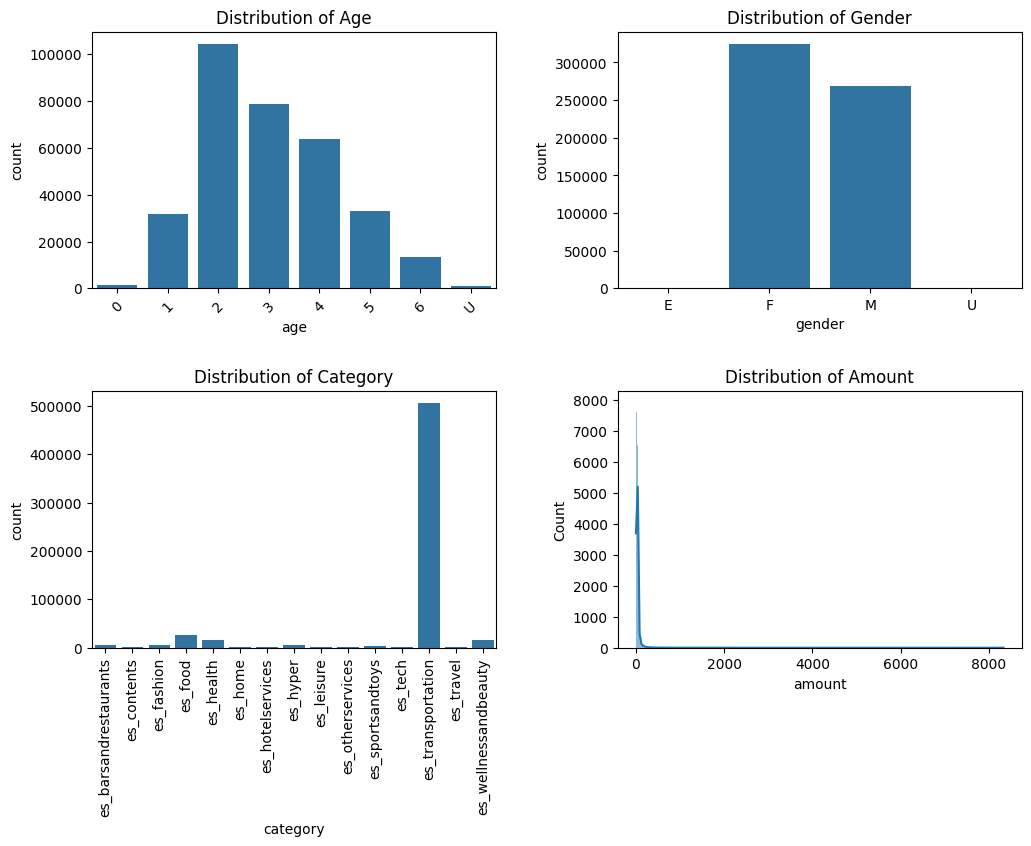

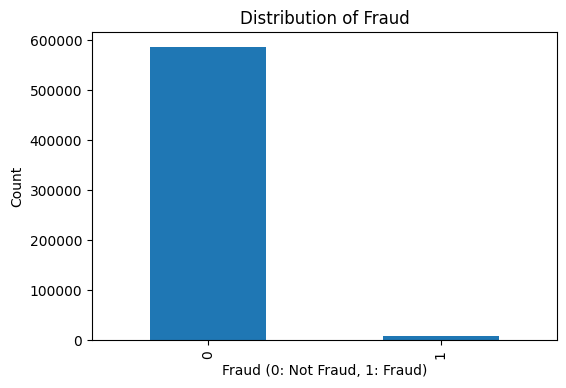

In [ ]:
plot_features(transactions_df)

In [ ]:
def target_analysis(df):
    """
    Performs target analysis using fraud =1,0 comparing across available features
    """

    colors = ["#0072B2", "#D55E00", "#CC79A7"]

    cols_to_exclude = ['customer', 'merchant', 'timestamp', 'fraud']
    for col in df.columns:
        if col not in cols_to_exclude:
            if pd.api.types.is_numeric_dtype(df[col]):
                plt.figure(figsize=(8, 6))
                sns.histplot(data=df, x=col, hue='fraud', palette=colors, element="step", kde=True)
                plt.title(f'{col} Distribution by Fraud')
                plt.xlabel(col)
                plt.ylabel('Frequency')
                if df[df['fraud'] == 1].shape[0]/df.shape[0] < 0.05:
                    plt.yscale('log')
                plt.show()

                plt.figure(figsize=(8,6))
                sns.scatterplot(data=df, x=col, y='fraud', hue='fraud', palette=colors)
                plt.title(f'Scatter Plot: {col} vs Fraud')
                plt.show()
            else:
                plt.figure(figsize=(8, 6))
                fraud_counts = df.groupby([col, 'fraud']).size().unstack()
                fraud_counts.plot(kind='bar', stacked=True, color=colors)
                plt.title(f'{col} Distribution by Fraud')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.show()

     # Extract time features
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['date'] = df['timestamp'].dt.date

    # Daily transactions by fraud
    daily_transactions = df.groupby(['day_of_week', 'fraud'])['fraud'].count().unstack()
    plt.figure(figsize=(10, 6))

    ax = daily_transactions.plot(kind='bar', stacked=True, color=colors)
    plt.title('Daily Transactions by Fraud')
    plt.xlabel('Day of Week')
    plt.ylabel('Count')

    day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax.set_xticklabels(day_labels)
    plt.show()


    # Hourly transactions by fraud
    hourly_transactions = df.groupby(['hour_of_day', 'fraud'])['fraud'].count().unstack()
    plt.figure(figsize=(12, 6))
    ax = hourly_transactions.plot(kind='bar', stacked=True, color=colors)
    plt.title('Hourly Transactions by Fraud')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.show()

<ipython-input-11-7f43fac5a7e2>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_counts = df.groupby([col, 'fraud']).size().unstack()


<Figure size 800x600 with 0 Axes>

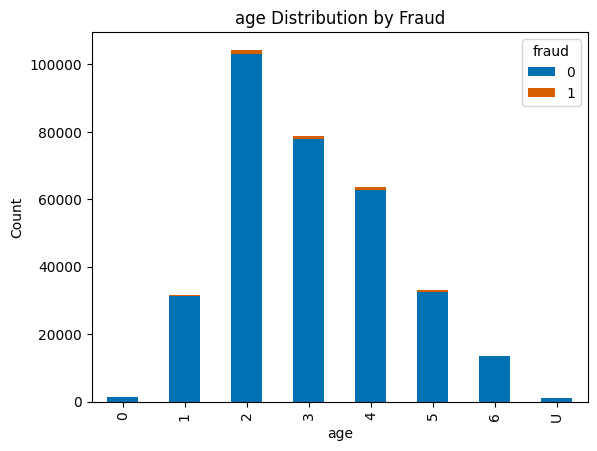

<ipython-input-11-7f43fac5a7e2>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_counts = df.groupby([col, 'fraud']).size().unstack()


<Figure size 800x600 with 0 Axes>

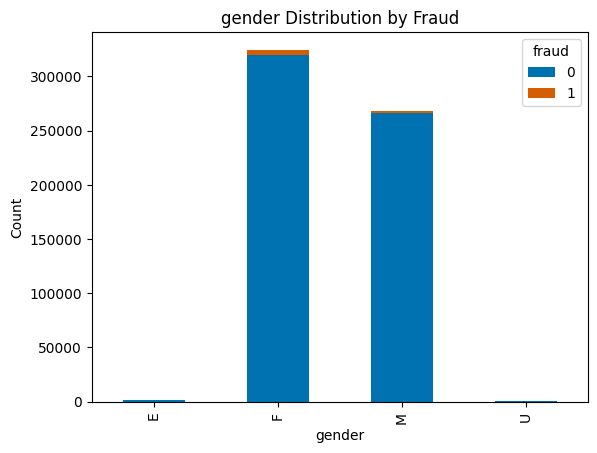

<Figure size 800x600 with 0 Axes>

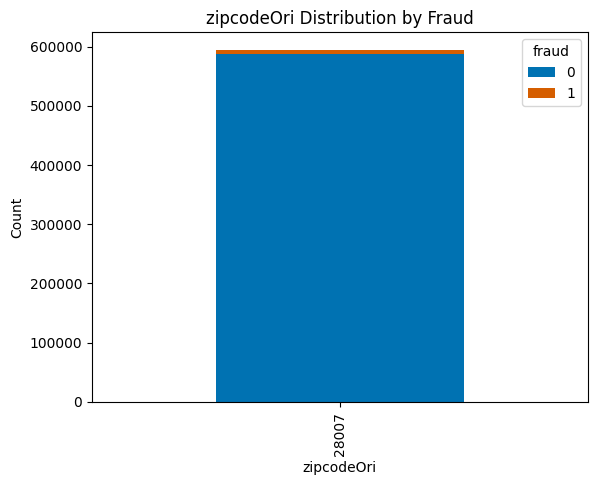

<Figure size 800x600 with 0 Axes>

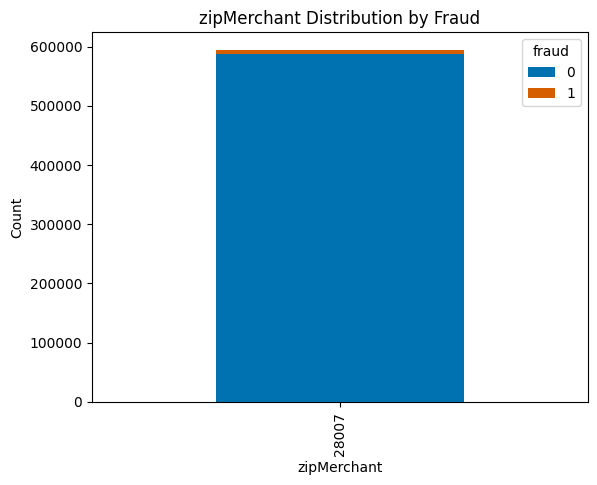

<ipython-input-11-7f43fac5a7e2>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_counts = df.groupby([col, 'fraud']).size().unstack()


<Figure size 800x600 with 0 Axes>

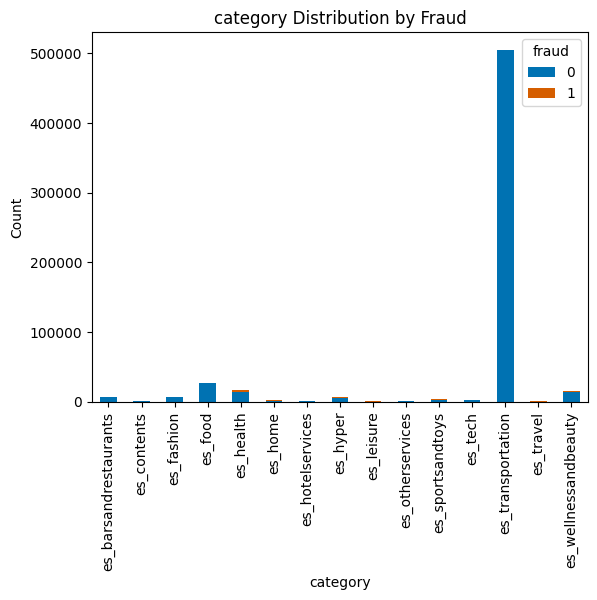

<ipython-input-11-7f43fac5a7e2>:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data=df, x=col, hue='fraud', palette=colors, element="step", kde=True)


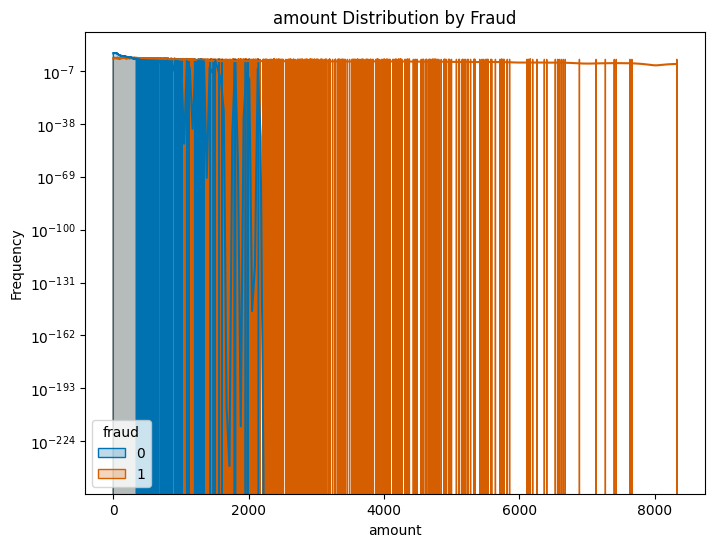

<ipython-input-11-7f43fac5a7e2>:22: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=df, x=col, y='fraud', hue='fraud', palette=colors)


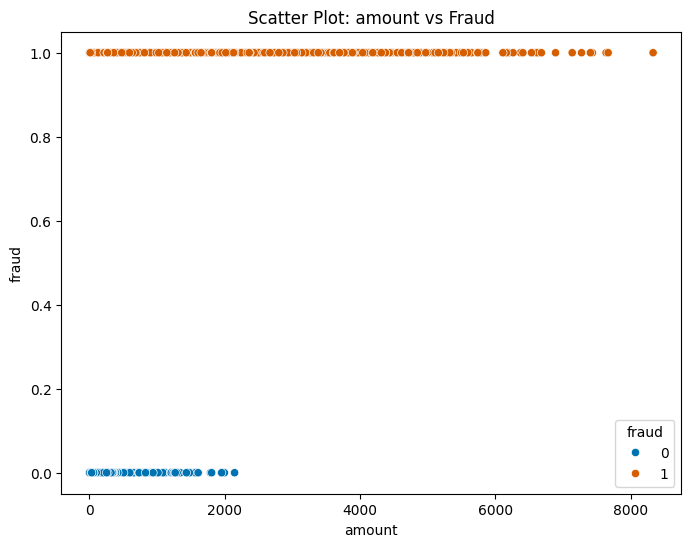

<Figure size 1000x600 with 0 Axes>

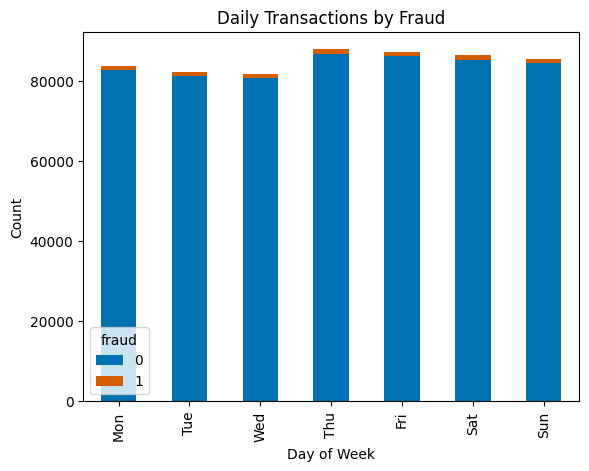

<Figure size 1200x600 with 0 Axes>

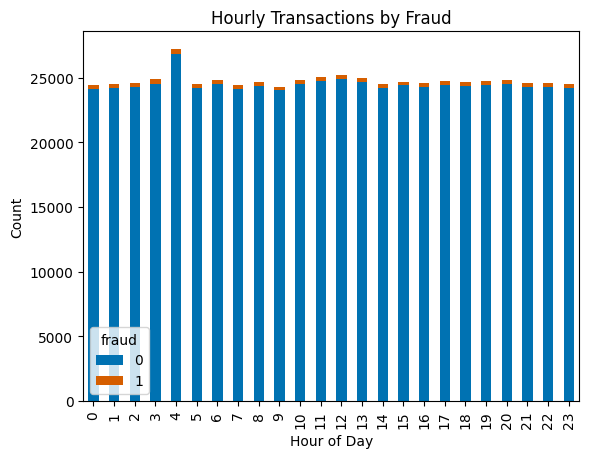

In [ ]:
target_analysis(transactions_df)

In [ ]:
transactions_df.columns

Index(['customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant',
       'category', 'amount', 'fraud', 'timestamp', 'day_of_week',
       'hour_of_day', 'month', 'date'],
      dtype='object')

**Sample Data Observations:**
- The given data sample has multiple customer and transaction related features along with fraud label.
- Based on descriptive statistics and exploratory analysis, fraud is very prevalent when transaction amount is high (>$2000). Additionally, transaction amount is right-skewed with lower transactions. We can confirm if this hypothesis is true during model evalulation and feature importance.
- The fraud label is highly imbalanced with only 1.2% of transactions as fraud and remaining non-fraud. Thus, we will need to handle data imbalance during model training.
- All the transactions are originated from zip code 28007, thus location based features will not provide much value.
- Transaction category is highly skewed with es_transportation being ~85%
- Target analysis also shows fraud is homogenous across other features except for amount as discussed above.

# Step 4: Feature Engineering

In [ ]:
def feature_engineering(df):
    """
    Creates a feature engineering df based on timestamp and amount to calculate metrics within
    specified time windows
    """
    df_fe = df.copy()

    # Define time windows
    time_windows = ["30d",  "72h", "24h"]
    # Aggregate functions
    agg_funcs = ["sum", "count", "mean", "std"]
    for window in time_windows:
        for func in agg_funcs:
            # Calculate rolling features
            feature_name = f"customer_amount_{func}_{window}"
            df_fe[feature_name] = df_fe.groupby("customer") \
                .apply(lambda g: g.rolling(window, on="timestamp", closed='left')["amount"].agg(func), \
                       include_groups=False).droplevel(1).values

    # Ratios
    ratios = {
        "24h": "72h",
        "72h": "30d",
        "24h": "30d"
    }
    for num_window, den_window in ratios.items():
        for func in ["sum", "count", "mean"]:
            num_feature = f"customer_amount_{func}_{num_window}"
            den_feature = f"customer_amount_{func}_{den_window}"
            ratio_feature = f"ratio_{num_window}_{den_window}_{func}"
            df_fe[ratio_feature] = df_fe[num_feature] / df_fe[den_feature]
            #Handle divide by zero
            df_fe[ratio_feature] = df_fe[ratio_feature].fillna(0)

    return df_fe

In [ ]:
feature_engineered_df = feature_engineering(transactions_df)

In [ ]:
feature_engineered_df.columns

Index(['customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant',
       'category', 'amount', 'fraud', 'timestamp', 'day_of_week',
       'hour_of_day', 'month', 'date', 'customer_amount_sum_30d',
       'customer_amount_count_30d', 'customer_amount_mean_30d',
       'customer_amount_std_30d', 'customer_amount_sum_72h',
       'customer_amount_count_72h', 'customer_amount_mean_72h',
       'customer_amount_std_72h', 'customer_amount_sum_24h',
       'customer_amount_count_24h', 'customer_amount_mean_24h',
       'customer_amount_std_24h', 'ratio_24h_30d_sum', 'ratio_24h_30d_count',
       'ratio_24h_30d_mean', 'ratio_72h_30d_sum', 'ratio_72h_30d_count',
       'ratio_72h_30d_mean'],
      dtype='object')

In [ ]:
def filter_first_30_days(df):
    """
    Filter rows for the first 30 days for each customer to avoid data leakage
    """
    # Sort by customer and timestamp
    df = df.sort_values(['customer', 'timestamp'])

    # Calculate the first transaction date for each customer
    first_transaction_date = df.groupby('customer')['timestamp'].min()

    # Create a new column indicating the first 30 days for each customer
    df['first_30_days'] = df.apply(lambda x: x['timestamp'] <= first_transaction_date[x['customer']] + pd.Timedelta(days=30), axis=1)

    # Split the dataframe
    first_30_days_df = df[df["first_30_days"]]
    rest_df = df[~df["first_30_days"]]

    # Drop the temporary 'first_30_days' column
    first_30_days_df = first_30_days_df.drop(columns=['first_30_days'])
    rest_df = rest_df.drop(columns=['first_30_days'])

    return first_30_days_df, rest_df

In [ ]:
first_30_days_df, filtered_fe_df = filter_first_30_days(feature_engineered_df)

In [ ]:
first_30_days_df.fraud.value_counts()

,count
fraud,
0,255225
1,2939


In [ ]:
filtered_fe_df.fraud.value_counts()

,count
fraud,
0,332218
1,4261



**Sample Setup:**
- Divide the data into train, validation and test.
- The test sample will be used to test for final model performance and estimate for $ fraud losses.

**Feature Engineering:**
- Calculated transaction based trended features at customer level like mean, standard deviation, sum and count in last 24 hours, 72 hours, 30 days and also added ratio of 24h:72h and so on. This is especially useful to evaulate the velocity of new transactions for a customer and helps identify if there is a significant change in the customer's recent transaction behavior.
- We also need to account for data leakage for first 30 days in the above scenario. I have used the full sample and replaced NaN values with mean in later stage due to the low fraud datapoints and limited analysis time. This is not the best solution and can be improved further.

# Step 5: Data Prep for Model Training

In [ ]:
def prepare_data(df, target_col='fraud'):
    X = df.drop(columns=[target_col, 'customer', 'merchant', 'zipcodeOri', 'zipMerchant', 'timestamp', 'date'])
    y = df[target_col]

    # One-hot encode categorical features
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Handle missing values
    X.fillna(X.mean(), inplace=True)

    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # Handle class imbalance using downsampling with 5:95 ratio for fraud: non-fraud
    rus = RandomUnderSampler(sampling_strategy=0.05, random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

    return X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test


In [ ]:
X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test = prepare_data(feature_engineered_df)

# Step 6: Model Training Setup

In [ ]:
def test_models(X_train, y_train):
    """
    Tests various classification models and tunes their hyperparameters.
    """
    models = {
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "LightGBM": LGBMClassifier(random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42)
    }
    param_grids = {
        "XGBoost": {
            'n_estimators': [10, 20, 50],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        },
        "LightGBM": {
            'n_estimators': [10, 20, 50],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [20, 50]
        },
        "Decision Tree": {'max_depth': [None, 10, 20]}
        }
    best_models = {}
    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[name], scoring='f1', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}") # Print best params
        print(f"Best recall score for {name}: {grid_search.best_score_}") #Print best score
    return best_models

In [ ]:
best_models = test_models(X_train_resampled, y_train_resampled)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best recall score for XGBoost: 0.8674054947562405
[LightGBM] [Info] Number of positive: 5040, number of negative: 100800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4328
[LightGBM] [Info] Number of data points in the train set: 105840, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047619 -> initscore=-2.995732
[LightGBM] [Info] Start training from score -2.995732
Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
Best recall score for LightGBM: 0.8684664048903256
Best parameters for Decision Tree: {'max_depth': 10}
Best recall score for Decision Tree: 0.8362202507610822


# Step 7: Model Evaluation

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    def evaluate_set(X, y, set_name):
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1]
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_prob)
        print(f"{set_name}:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        return precision, recall, f1, roc_auc, y_prob, y
    print(f"Evaluating {type(model).__name__}:")
    train_metrics = evaluate_set(X_train, y_train, "Train")
    val_metrics = evaluate_set(X_val, y_val, "Validation")

    # ROC Curve and PR Curve
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    for metrics, set_name, color in zip([train_metrics, val_metrics], ["Train", "Validation"], ['blue', 'red']):
        y_prob, y_true = metrics[4], metrics[5]
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        roc_auc = roc_auc_score(y_true, y_prob)
        axes[0].plot(fpr, tpr, label=f'{set_name} (AUC = {roc_auc:.3f})', color=color)
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc='lower right')

    # PR Curve
    for metrics, set_name, color in zip([train_metrics, val_metrics], ["Train", "Validation"], ['blue', 'red']):
        y_prob, y_true = metrics[4], metrics[5]
        precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall_curve, precision_curve)
        axes[1].plot(recall_curve, precision_curve, label=f'{set_name} (PR-AUC = {pr_auc:.3f})', color=color)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('PR Curve')
    axes[1].legend(loc='lower left')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

Evaluating XGBoost:
Evaluating XGBClassifier:
Train:
  Precision: 0.9243
  Recall: 0.8405
  F1 Score: 0.8804
  ROC AUC: 0.9968
Validation:
  Precision: 0.6974
  Recall: 0.8324
  F1 Score: 0.7590
  ROC AUC: 0.9967


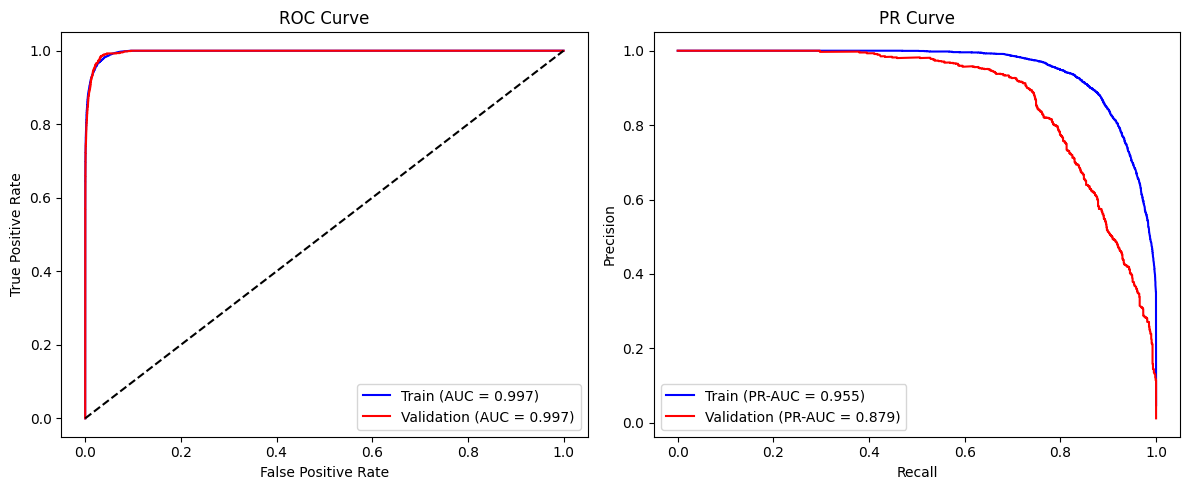

Evaluating LightGBM:
Evaluating LGBMClassifier:
Train:
  Precision: 0.9243
  Recall: 0.8522
  F1 Score: 0.8868
  ROC AUC: 0.9975
Validation:
  Precision: 0.6938
  Recall: 0.8435
  F1 Score: 0.7614
  ROC AUC: 0.9969


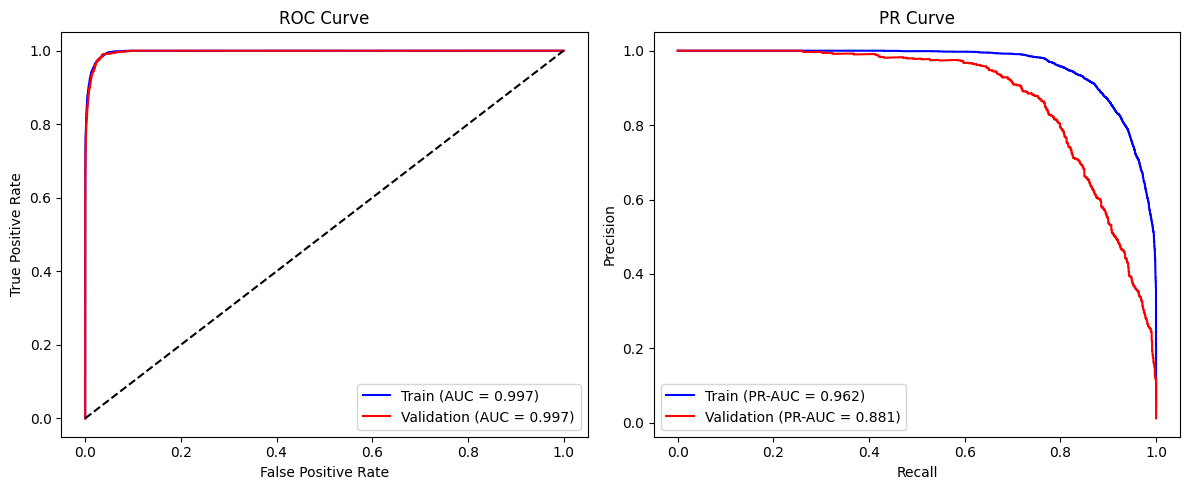

Evaluating Decision Tree:
Evaluating DecisionTreeClassifier:
Train:
  Precision: 0.9653
  Recall: 0.8671
  F1 Score: 0.9136
  ROC AUC: 0.9973
Validation:
  Precision: 0.6611
  Recall: 0.8037
  F1 Score: 0.7254
  ROC AUC: 0.9733


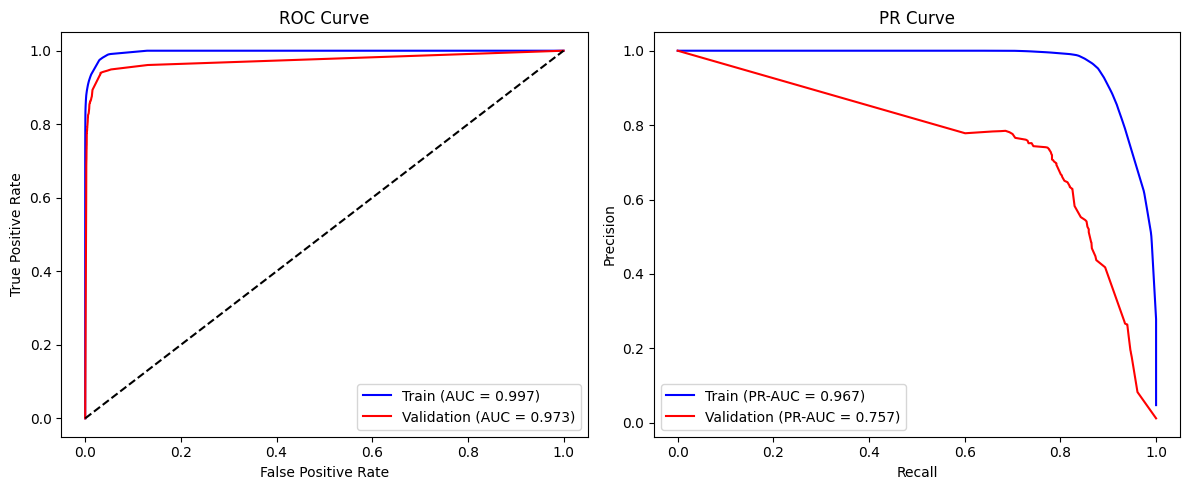

In [ ]:
for name, model in best_models.items():
    print(f"Evaluating {name}:")
    evaluate_model(model, X_train_resampled, y_train_resampled, X_val, y_val)


**Modelling Setup:**

- Data:
 - Convert features to one-hot encoding, replace missing values with mean and handle class imbalance with downsampling only on train data to achieve 95:5 ratio for non-fraud: fraud
 - I have not normalized any features for now, as there were no known outliers in the data or extreme values to be scaled.
- Model:
 - Tried multiple tree based algorithms for the evaluation: Decision Tree, Xgboost and LightGBM.
 - Used a limited number of hyperparameters for faster training time. However, this can be further optimized given more time.
 - Used Grid Search for cross-validation and select the best parameters for the model.
- Metrics Evaluation:
  - Since this is a fraud use case, we need a very high Recall but also the downside can be low Precision and thus a lot of false-positives for the fraud agents to evaluate. Thus I have used F1-score to optimize during Grid Search.
  -I have also added ROC and PR AUC to compare the different models.

# Step 8: Feature Importance and SHAP Values

In [ ]:
def get_feature_importance_and_plot_shap(best_model, X_train, X_val):
  #Feature importance
  importances = best_model.feature_importances_
  feature_names = X_train.columns
  importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
  importance_df = importance_df.sort_values(by='Importance', ascending=False)
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Importance', y='Feature', data=importance_df)
  plt.title('Feature Importance')
  plt.show()

  # SHAP values
  explainer = shap.TreeExplainer(best_model)
  shap_values = explainer.shap_values(X_val)
  shap.summary_plot(shap_values, X_val)
  plt.show()

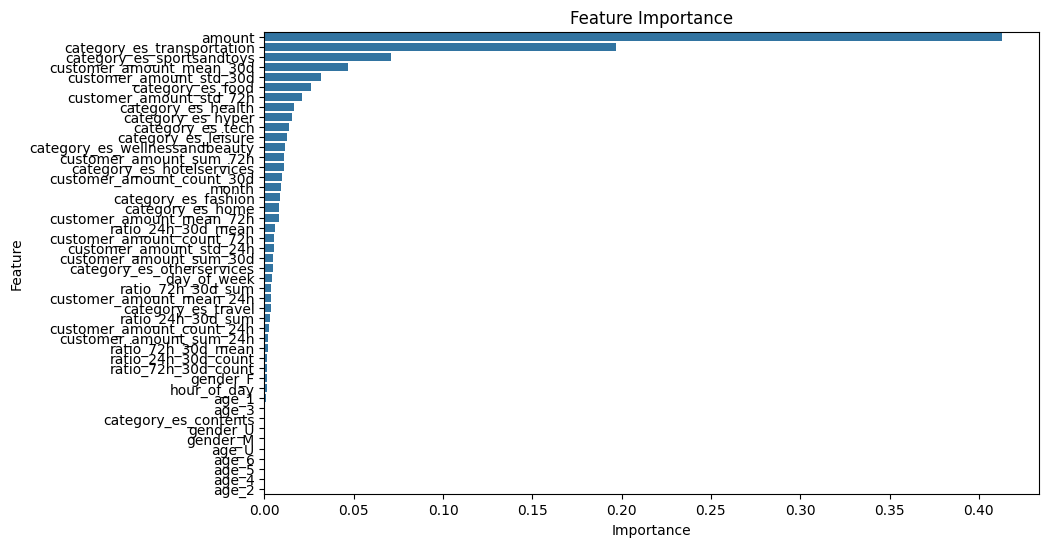

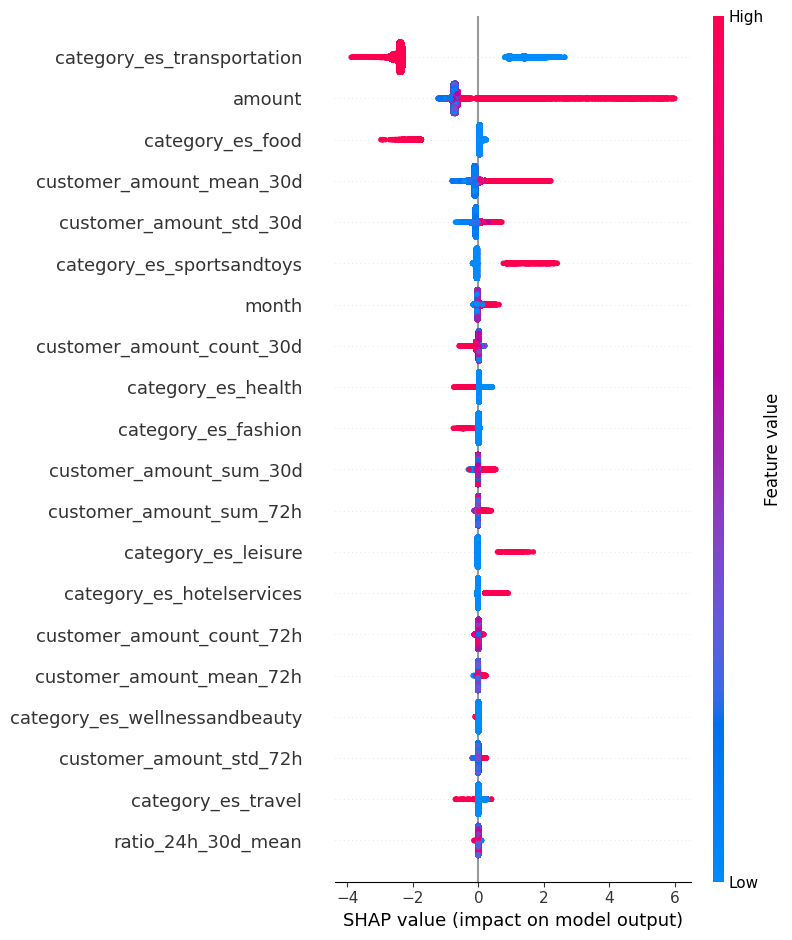

In [ ]:
get_feature_importance_and_plot_shap(best_models['XGBoost'], X_train_resampled, X_test)

# Step 9: Final Model Selection

In [ ]:
best_model = best_models['XGBoost']
params = best_model.get_params()
params

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 50,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


**Model Choice:**  
 - Based on model performance, Xgboost and LightGBM both seem to be performing well. Thus, I have picked Xgboost as a model of choice as it can be further optimized with extensive hyperparameter tuning options.

**Limitations:** The model is likely overfitting given the difference in train and test metrics for Precision, Recall, F1 and ROC AUC. This can be further optimized using features elimination and hyperparameter tuning.

# Step 10: Business Evaluation Metrics and Fraud Losses Estimation

In [ ]:
# Predict probabilities for X_test
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

pred_proba_df = pd.DataFrame({'y_pred_proba': y_pred_proba})

# Rank order percentiles
pred_proba_df['percentile'] = pred_proba_df['y_pred_proba'].rank(pct=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

results_df = pd.concat([X_test, y_test, pred_proba_df], axis=1)

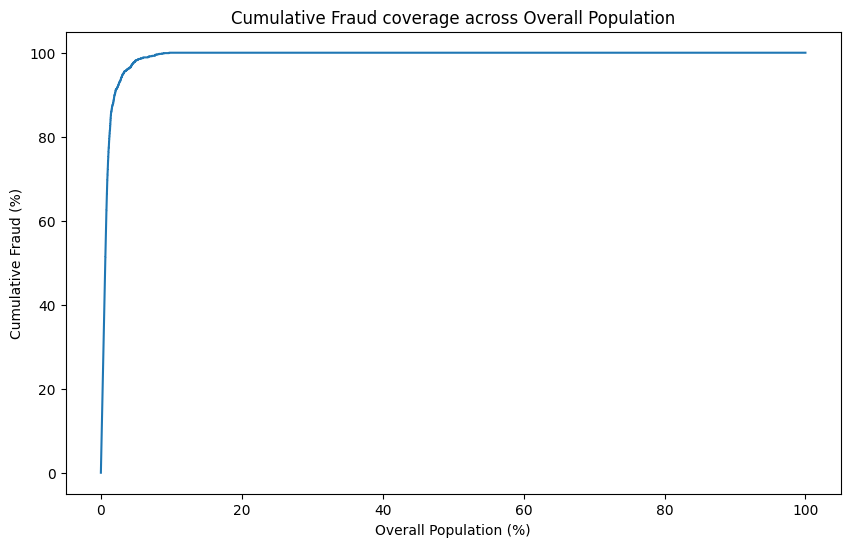

In [ ]:
results_df['fraud_count'] = results_df['fraud']
results_df = results_df.sort_values(by='percentile', ascending=False)
results_df['cumulative_fraud_percent'] = results_df['fraud_count'].cumsum() / results_df['fraud_count'].sum() * 100
results_df['cumulative_population_percent'] = np.arange(1, len(results_df) + 1) / len(results_df) * 100

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(results_df['cumulative_population_percent'], results_df['cumulative_fraud_percent'], linestyle='-')
plt.xlabel('Overall Population (%)')
plt.ylabel('Cumulative Fraud (%)')
plt.title('Cumulative Fraud coverage across Overall Population')
plt.show()

In [ ]:
# Filter for transactions above the 80th percentile
top_80_percentile_fraud = results_df[results_df['percentile'] >= 0.8].copy()

# Calculate dollar value saved per fraud transaction
top_80_percentile_fraud['dollar_value_saved'] = top_80_percentile_fraud['amount'] * top_80_percentile_fraud['fraud']

# Calculate total dollar value saved
total_dollar_value_saved = top_80_percentile_fraud['dollar_value_saved'].sum()

# Calculate the number of fraud transactions
num_fraud_transactions_top_80 = top_80_percentile_fraud['fraud'].sum()

# Calculate average dollar value saved per fraud transaction
avg_dollar_value_saved_per_fraud=(total_dollar_value_saved/num_fraud_transactions_top_80
                                  if num_fraud_transactions_top_80 > 0
                                  else 0)
print("Average dollar value saved per fraud transaction: $"f"{avg_dollar_value_saved_per_fraud:.2f}")

# Calculate the total number of transactions
total_transactions = len(results_df)

# Calculate average fraud dollar value saved per transaction
average_fraud_dollar_saved_per_transaction=(total_dollar_value_saved/total_transactions
                                            if total_transactions>0
                                            else 0)

print("Average fraud dollar value saved per all transactions: $"f"{average_fraud_dollar_saved_per_transaction:.2f}")

Average dollar value saved per fraud transaction: $517.23
Average fraud dollar value saved per all transactions: $6.26



**Business Evaluation and Model Usage:**

- I used the Test data here to predict the probabilities and further rank ordered them in percentiles. It can then be used to assign every transaction score with a fraud score percentile.
- This percentile can then be used as a threshold for rules based decision for fraud agents to review the transaction.
- For eg. I have plotted Fraud coverage across all transactions and the model is able to cover 80% fraud within top 20 percentile of transactions. Thus we can define a rules based threshold for top 20 percentile of all transactions.

**Fraud Losses Estimation:**
- Using the above 20 percentile threshold, I calculate 2 metrics:
 - Average dollar value saved per fraud transaction: `$`517.23
 - Average fraud dollar value saved per all transactions `$`6.26
- So in a given calendar year if we have 100k transactions, the potential savings would be ~`$`626k per year if we were to implement this model.
- While this is purely an estimate and the actual value can be further refined, it gives a good direction whether the model should be implemented or not. In this case the recommendation would be to implement the model if it outperforms any existing rules alongwith other cost considerations like operational cost to manually decision each flagged transaction, etc.

